<a href="https://colab.research.google.com/github/divyanshgupt/travelling-wave-mec/blob/main/Grid_Cells_with_Theta_Rhythm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
#import torch

## Introduction
In the early 2000s, the Mosers investigated spatial representations and how the place cell code comes about in the hippocampus by examining the nearby regions. They found cells in the medial entorhinal cortex with hexagonal lattice receptive fields in 2-D space in the rat environment (Hafting et al., 2005), these came to be called ‘grid cells.’ Since then there has been a flurry of work characterizing the properties of these cells, how the grid cell code relates to the place cell code (Solstad et al., 2006), representational capacity of modular representations (Fiete et al., 2008), how the grid cell populations exist in discrete modules (Stensola et al., 2012) etc. 

Hernandez-Perez and others found recently that travelling waves, which have been observed in the hippocampus (Lubenov and Siapas, 2009) are also observed in the medial entorhinal cortex in the rat (Hernández-Pérez et al., 2020). These travelling waves exist as gradual phase offsets in the theta rhythm from the dorsal to the ventral end of the entorhinal cortex.

Various methods have been proposed to read grid cell code including network-based approaches that involve learning; in 2015, a simple but powerful method was proposed based on well-known ideas of population vector decoding of neural activity (Stemmler et al., 2015). Stemmler and others used von Mises tuning curves to model grid cell activity and used population vector decoding to optimally decode the animal position from population activity across grid cell modules in a nested manner. But the grid cell model the authors used incorporated neither a theta rhythm & phase precession nor travelling waves. 

How travelling waves affect grid cell activity and potential downstream inference of position is not well understood. Here, we try to look at the performance of the nested population vector decoding approach suggested by Stemmler and others in the context of a travelling wave and theta phase precession by extending a model for phase precession developed in the context of place cell activity (McClain et al., 2019). We find as expected that the performance of the decoder is synchronized with the theta rhythm at the single module level. It would be interesting to see how the nested decoder fares with the theta offset provided by the travelling wave.

In [ ]:
#@title Module Generator

def uniform_module(lam, nb_cells):
  """
  Input:
    lam - spatial period of the module
    nb_cells - number of cells in the module
  Returns:
    Matrix of shape (cell_num_root^2, 2), containing the x & y components of the 
    preferred phase of each cell in column 1 and 2.
  """
  module = np.random.uniform(low = 0, high = lam, size = (nb_cells, 2))
  return module

def test_uniform_module(lam=10, nb_cells=100):
  module = uniform_module(lam, nb_cells)
 # print(module)
  plt.plot(module[:, 0], module[:, 1], '.')
  plt.title("Preferred Phases in the Module")
  plt.xlabel('x')
  plt.ylabel('y')
#test_uniform_module()


In [ ]:
#@title Multi-module Generator

def multi_uniform_modules(args):
  """
  Generates preferred phases of cells in each module
  Input: 
    lam: spatial period of the largest module
    num_cells: number of cells in each module
    s: scaling ratio of spatial periods in each module
    num_modules: number of modules
  Returns:
    3-D Matrix of shape: (nb_cells, 2, nb_modules)
  """
  s = args['scaling_ratio']
  nb_modules = args['nb_modules']
  nb_cells = args['nb_cells']
  lam = args['lam_0']
  modules = np.zeros((nb_cells, 2, nb_modules))

  for i in range(nb_modules):
    lam_i = lam / (s**i)
    modules[:, :, i] = uniform_module(lam_i, nb_cells)
  
  return modules

def test_multi_uniform_modules(lam=10, s=1.5, nb_modules=4, nb_cells=100):
  modules = multi_uniform_modules(lam, s, nb_modules, nb_cells)
  for i in range(nb_modules):
    plt.plot(modules[:, 0, i], modules[:, 1, i], '.')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title("Preferred Phases in Module " + str(i + 1))
    plt.show()

#test_multi_uniform_modules()

### Von Mises Tuning curves
Von Mises tuning curves are periodic generalizations of Gaussians. They were chosen because of their ability to fit experimentally observed neural tuning curves (Herz et al., 2017) and their theoretical appeal (see Maximum Likelihood Estimate, Methods) in that the population vector estimate becomes the maximum likelihood estimate. 

In one dimension these von-mises curves can be modelled as:
$$ \Omega_j(x) = n_{max}e^{k(cos(x) - 1)} $$
Extending these to a two-dimensional hexagonal lattice can be done by representing the hexagonal lattice as the superposition of three sinusoidal plane waves (Solstad et al., 2006):

$$ \Omega_j(\vec{x}) =  n_{max}e^{\frac{\kappa}{3} \Sigma_{l=1}^3(cos(\omega \vec{k_l}\bullet (\vec{x} - \vec{c_j})) - 1)}$$

Where $k_l = (cos\phi_l, sin\phi_l)$ such that $\phi_l = -\pi/6 +l\pi/3 $; $n_{max}$: maximum firing rate of the cell

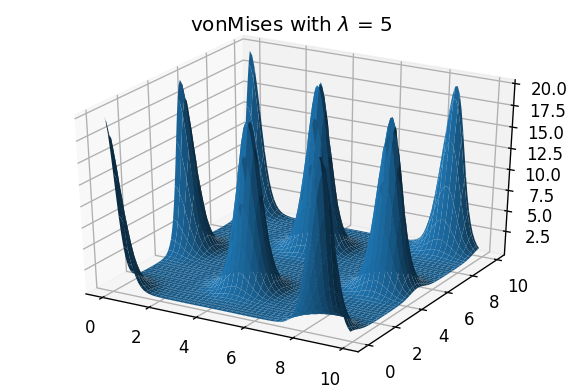

In [9]:
#@title Spatial Input (von Mises)
def von_mises(position, lam, module, args):
  """
  Inputs:
    position: x, y coordinates
    lam: spatial period of the grid cell lattice
    kappa: von-mises tuning-width
    module: preffered phases of all grid cells, shape: (nb_cells, 2)

  Returns:
    values of the von-mises tuning curve for a given module
    at the given position with the given parameters, shape: (nb_cells,)
  """
  pi = np.pi

  K = args['K']
  n_max = args['n_max']

  k_1 = np.array([np.cos(pi/6), np.sin(pi/6)])
  k_2 = np.array([np.cos(pi/2), np.sin(pi/2)])
  k_3 = np.array([np.cos(pi*5/6), np.sin(pi*5/6)])
  plane_vectors = np.vstack((k_1, k_2, k_3)) # final shape: (3, 2)

  w = 2*pi / (np.sin(pi/3)*lam)  

  position_arg = position - module  # final shape: (nb_cells, 2)
  dot_prod = plane_vectors @ position_arg.T # final shape: (3, nb_cells)
  tuning_values = n_max*np.exp((K/3) * np.sum(np.cos(w * dot_prod) - 1, axis=0))

  return tuning_values

## To visualize the von Mises curves:


def plot_3D(x, y, z, title):
  '''
  Parameters:
  x: 1-D array of x values
  y: 1-D array of y values
  z: 2-D array of z values
  title: type(str)

  Plots the given data in 3D
  '''
  X,Y = np.meshgrid(x,y)
  fig = plt.figure(dpi=120) # initialize plot
  ax = plt.axes(projection='3d')

  ax.plot_surface(X, Y,z)

  ax.set_title(title)
  plt.show()

def tuning_generator(x_range, y_range, step_size, arg, verbose=False):
  x = np.arange(0, x_range, step_size)
  y = np.arange(0, y_range, step_size)

  result = np.zeros((int(x_range/step_size), int(y_range/step_size)))
  iteration = 1

  for x_idx, i in enumerate(x):
    for y_idx, j in enumerate(y):
      # goes through each x and y value and store the vonMises value in the 2-D array 'result'
      position = np.array([i,j])
      result[x_idx, y_idx] = von_mises(position, arg['lam'], np.array([0,0]), arg)
      if verbose == True:
        print('Iteration:', iteration)
      iteration += 1

  return x, y, result


arg = {'lam':5,
        'n_max': 20,
        'K': 5}
x, y, tuning = tuning_generator(x_range=10, y_range=10, step_size=0.1, arg=arg)

plot_3D(x, y, tuning, 'vonMises with $\lambda$ = ' + str(arg['lam']))


### Position Theta Phase Model from McClain et al., 2019:

**Spatial Input Equation**: (Gaussian to model place cell field)
$$ f = e^{A_x}e^{\frac{-(x-x_0)^2}{2\sigma^2_x}}  $$

**Phase modulation equation**:
$$ g(\theta,x) = e^{k_\theta(cos(\theta - \theta_0(x)) - 1)} $$

**Phase precession equation**:
$$ \theta_0(x) = b_\theta + m_\theta(x - x_0) $$

$ b_\theta = 0 $: preferred phase at the center of the place field

$ m_\theta = 1 $: rate of phase precession

**Rate** (modelled as a product of the spatial input and phase modulation equations):
$$ r(x, \theta) = f(x)\bullet g(\theta, x) $$

### Extension of Position Theta Phase Model for Grid Cells:

**Spatial Input Equation** (von Mises tuning for grid fields):
$$ \Omega_j(\vec{x}) =  n_{max}e^{\frac{\kappa}{3} \Sigma_{l=1}^3(cos(\omega \vec{k_l}\bullet (\vec{x} - \vec{c_j})) - 1)}$$

**Phase modultion equation**:    
$$ g(\theta, \vec{x}) = e^{k_\theta(cos(\theta - \theta_0(\vec{x}))-1)} $$

**Phase precession (2-D)**:
$$ \theta_0(\vec{x}) = b_\theta + m_\theta(|\vec{x} - \vec{x_0}|)  $$


**Rate**:
$$ r(\vec{x}, \theta) = f(x)\bullet g(\theta, \vec{x})$$

In [ ]:
#@title Phase Precession
def theta_precess(position, args):
  """
  Evaluates theta_0 based on position (models phase precession)
  Input:
    trajectory: position coordinates, shape: (path_length, 2)
    args: ['b_theta', 'm_theta', 'ref_pos']
  Returns:
    Theta_0: shape:(path_length,)
  """
  b_theta = args['b_theta']
  m_theta = args['m_theta']
  ref_pos = args['ref_pos']

 # print(type(position))

  theta_0 = b_theta + m_theta*(np.linalg.norm(position - ref_pos, axis=1))
  return theta_0

# the test function is wrong
def test_theta():
  x_coord = np.arange(0, 1000, 0.1)
  y_coord = np.arange(0, 1000, 0.1)
  size = len(x_coord)
  x_y = np.zeros((size, size, 2)) # this is wrong
  for i in range(len(x_coord)):
    x_y[i, :, 0] = x_coord
    x_y[i, :, 1] = y_coord
  
  theta_0 = theta_precess(x_y, np.zeros_like(x_y))
  print("Theta shape:", theta_0.shape)
  plt.imshow(theta_0)
  plt.colorbar()
#  plt.xticks()

#test_theta()

In [ ]:
#@title Phase Modulation
def phase_modulation(theta, position, args):
  """

  Inputs:
    theta: theta oscillations, shape: (nb_steps,)
    position: animal position coordinates, shape:(2,)
    args: ['k_theta']
  Returns:
    g
  
  """
  k_theta = args['k_theta']

  g = np.exp(k_theta*(np.cos(theta - theta_precess(position, args)) - 1))

  return g

#def test_phase_modulation():


#test_phase_modualtion()

### Theta Oscillation Parameters:

$$ f = 4-12 Hz $$
$$ \omega = 2\pi f = 8\pi - 24\pi$$

Question: What is the total phase offset from the ventral to the dorsal end? (Ref. Hernandez-perez et al., 2020)
Assumed value: Around 40 degrees.

Here, in the code below theta_oscillation function returns an array containing the value of the theta phase for each module at each time point. The theta phase for subsequent modules is shifted by a phase offset dictated by the travelling wave. And 

In [ ]:
#@title Theta Rhythm
def theta_oscillations(args):
  """
  Generates theta oscillations incorporating the traveling wave.
  Assumption: all modules are lined up one after the other from the dorsal to
  the ventral end
  Inputs:
    args: ['nb_steps', 'timestep_size', 'theta_freq', 'nb_modules']
  Returns:
    theta: theta values for all modules all
           timesteps, shape:(nb_modules, nb_steps)
  """

  nb_steps = args['nb_steps']
  dt = args['timestep_size']
  freq = args['theta_freq']
  nb_modules = args['nb_modules']
  phi = args['phase_offset']

  pi = np.pi

  omega = 2*pi*freq
 
  phi =  phi * pi/180 # total theta phase offset from ventral to dorsal end

  theta = np.zeros((nb_modules, nb_steps))
  for i in range(nb_modules):
    theta[i] = np.arange(i*phi/nb_modules,
                                (i*phi/nb_modules) + (omega*dt*nb_steps),
                                omega*dt)
  return theta

def visualize_theta(theta, args):

  nb_modules = args['nb_modules'] 
  nb_steps = args['nb_steps']
  dt = args['timestep_size']
  
  for i in range(nb_modules):
    plt.figure(dpi=100)
    plt.plot(np.cos(theta[i]))
    plt.title("Theta at Module " + str(i + 1))
    plt.xlabel("Timestep (of length " + str(dt) + ' secs)')
    plt.ylabel("Amplitude")
    plt.show()

theta = theta_oscillations(args)
visualize_theta(theta, args)

### Independent Poisson Spiking

Grid cells are modelled as independent Poisson processes, with the mean firing rate value obtained from the von misses tuning curve at the specific x-y coordinates. 
Without the theta rhythm, the firing activity is obtained stochastically from the probability distribution:
$$ P(n_j | \vec{x}) = \frac{\Omega_j^{n_j}(\vec{x})e^{\Omega_j(\vec{x})}}{n_j!}$$


In [ ]:
#@title Firing Activity

def firing_activity(trajectory, modules, args):
  """
  Generates Firing Activity for all cells in all modules for a
  given trajectory.
  Assumption: Neurons show independent poisson spiking
  Inputs:
    trajectory: 2-D matrix with x & y coordinates in column 1 and 2, for the path
    modules - 3-D matrix with preferred phases
              of all cells in each module, shape: (nb_cells, 2, nb_modules)
    args: ['timestep_size', 'nb_modules', ]

  Returns:
    firing activity, shape: (nb_cells, nb_steps, nb_modules)
  """
  dt = args['timestep_size']
  nb_steps = args['nb_steps']
  nb_modules = args['nb_modules']
  nb_cells = args['nb_cells']
  freq = args['theta_freq']
  phi = args['phase_offset'] # total phase offset from dorsal to ventral end
  lam_0 = args['lam_0']
  s = args['scaling_ratio']
  pi = np.pi

  theta = theta_oscillations(args) # shape: (nb_modules, nb_steps)

  firing_activity = np.zeros((nb_cells, nb_steps, nb_modules))
  g_rec = np.zeros((nb_modules, nb_steps)
  )
  for t in range(nb_steps):

    position = trajectory[t]

    for j in range(nb_modules): # iterate from largest to smallest module
      lam = lam_0/(s**j)
      
      g = phase_modulation(theta[j, t], position, args) # shape: (1,)
      g_rec[j, t] = g
      f = von_mises(position, lam, modules[:, :, j], args) # shape: (nb_cells,)
      r = f * g # shape: (nb_cells,)
      firing_activity[:, t, j] = np.random.poisson(r*dt, size=nb_cells)

  return firing_activity, g_rec

def visualize_firing(ctivity, args, i=0):
  """
  Inputs:
    activity: shape(nb_cells, nb_steps)
    args
    i - module no. to visualize
  Returns:
    
  """
  nb_modules = args['nb_modules']
  nb_steps = args['nb_steps']
  dt = args['timestep_size']
  nb_cells = args['nb_cells']

  positions = np.arange(0, nb_steps, dt)
  positions = positions[activity != 0] 
  plt.eventplot(positions)
  plt.title("Module no: " + str(i + 1))
  plt.xlabel("Timestep")
  plt.ylabel("Cell No:")
  plt.show()



In [ ]:
#@title Stationary Trajectory
def stationary_trajectory(x_coord, y_coord, args):
  """
  Generates stationary trajectory for given position coordinates
  for given nb_steps
  Inputs:
    x_coord:
    y_coord:
    args: ['nb_steps']
  Returns:
    trajectory: 
  """
  nb_steps = args['nb_steps']
  x = x_coord * np.ones(nb_steps)
  y = y_coord * np.ones(nb_steps)

  trajectory = np.column_stack((x, y))

  return trajectory


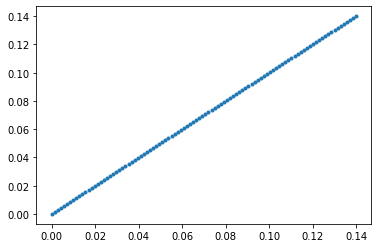

In [ ]:
#@title Straight Trajectory

def straight_trajectory(angle, args):
  """

  """

  velocity = args['animal_velocity']
  dt = args['timestep_size']
  nb_steps = args['nb_steps']
  phi = angle * np.pi / 180

  x = np.arange(0, np.cos(phi)*velocity*dt*nb_steps,
                np.cos(phi)*velocity*dt)
  y = np.arange(0, np.sin(phi)*velocity*dt*nb_steps,
                np.sin(phi)*velocity*dt)

  trajectory = np.column_stack((x, y))

  return trajectory

trajectory = straight_trajectory(45, args)
plt.plot(trajectory[:, 0], trajectory[:, 1], '.')

In [ ]:
#@title Trajectory Plotter

def plot_trajectory(trajectory):
  """
  Inputs:

  Returns:

  """
  plt.plot(trajectory[:, 0], trajectory[:, 1], '.')
  plt.show()
  

### Population Vector Decoding

The idea of population vector decoding is to assign a vector to each neuron with its direction representing the preferred direction/phase of the cell. Then a sum of these vectors weighted by the firing activity of the respective neurons represents the population vector, whose direction encodes the phase/direction of the underlying variable, in this case, the animal position. The method used here, for single module and for nested decoding is as suggested in Stemmler et al., 2015. 


As has been shown before (Mathis et al., 2013), under four assumptions, the maximum likelihood estimate and the population vector-based estimate are identical: 
1. Neurons fire independently, so that:	$ P(\vec{n}|x) = \Pi^{N}_{j=1}P(n_j|x) $
2. They obey Poisson Statistics:   i.e. $ P(n_j | \vec{x}) = \frac{\Omega_j^{n_j}(\vec{x})e^{\Omega_j(\vec{x})}}{n_j!}$
3. Von Mises Tuning:  i.e. $\Omega_j(\vec{x}) =  n_{max}e^{\frac{\kappa}{3} \Sigma_{l=1}^3(cos(\omega \vec{k_l}\bullet (\vec{x} - \vec{c_j})) - 1)}$
4. Even for relatively small N, $ \Sigma_j^N \Omega_j(x) = 1$ and given 1 & 2:	$ P(n|x) \sim \Sigma^N_{j=1}\Omega_j^{n_j}(x)$

In [ ]:
#@title Populationg Vector Decoder for Single Module
def pop_decode(firing_activity, lam, args, module):
  """
  Generates population vector estimate based on giving firing activity
  of a single module
  Inputs:
    firing_activity - shape:(nb_cells, nb_steps)
    args - ['']
    module - shape: (nb_cells, 2)
  Returns:
    estimates - shape:(nb_steps,)
  """
  nb_steps = args['nb_steps']

  pi = np.pi

  k_1 = np.array([np.cos(pi/6), np.sin(pi/6)])
  k_2 = np.array([np.cos(pi/2), np.sin(pi/2)])
  k_3 = np.array([np.cos(pi*5/6), np.sin(pi*5/6)])

  plane_vectors = np.vstack((k_1, k_2, k_3)) # shape: (3, 2)

  w = 2*pi/(np.sin(pi/3)*lam)

  estimates = np.zeros((nb_steps, 2))

  for t in range(nb_steps):
    pop_vector = np.sum(firing_activity[:, t] *  np.exp(1j*w*(plane_vectors @ module.T )), axis=1) # final shape: (3,)
    mu = 1/w * np.angle(pop_vector) # shape: (3,)

    estimates[t] = (2/3) * (mu.T @ plane_vectors) #shape: (2,)

  return estimates

In [ ]:
#@title Squared-Error
def sq_error(estimates, true_pos):
  """
  Evaluates squared error at each step from the true position
  Inputs:
    estimates - shape:(nb_steps, 2)
    true_pos - shape:(p, 2) where p = 1 or nb_steps
  Returns:
    mse_error - shape(nb_steps)
  """

  error = np.sum((estimates - true_pos)**2, axis=1) #shape: (nb_steps,)

  return error #shape: (nb_steps)

### Testing Everything

In [ ]:
#@title Args

args = {'timestep_size': 0.01, # sec
        'nb_steps': 100, # simulation time = dt*nb_steps (secs)
        'nb_modules': 5,
        'nb_cells': int(1e4),
        'lam_0': 100,  #spatial period of largest module (ventral)
        'K': 50, # von-Mises tuning width
        'n_max': 20, # maximum firing rate
        'animal_velocity': 0.2, # m/sec
        'theta_freq': 8,  # Hz
        'phase_offset': 40, # degrees 
        'scaling_ratio': 1.5,
        'k_theta': 1,
        'b_theta': 0,
        'm_theta': 2*np.pi/10, # rate of theta precession
        'ref_pos': np.array([[0, 0]]),  # reference position for theta precession
        }

In [ ]:
#@title Initializing Modules

modules = multi_uniform_modules(args)

In [ ]:
#@title Single timepoint

position = np.array([[6, 5]]) # shape: (1,2)
print("Actual Position:", position)
args['nb_steps'] = 1

activity, theta = firing_activity(position, modules, args)

# Estimating at Module - 0
estimates = pop_decode(activity[:, :, 0], args['lam_0'], args, modules[:, :, 0])
print("Estimated Position:", estimates)


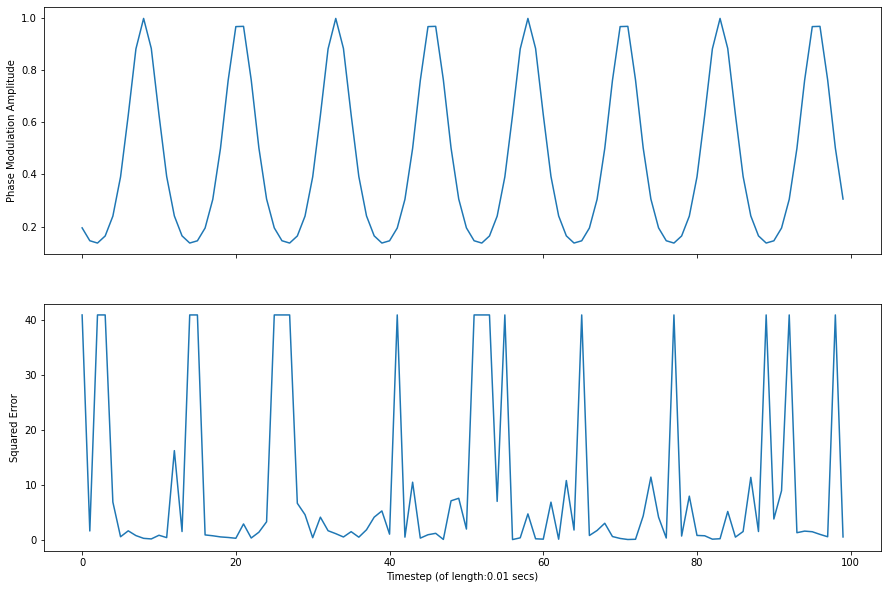

In [ ]:
#@title Stationary Animal
x = 4
y = 5
trajectory = stationary_trajectory(x, y, args)

activity, g_rec = firing_activity(trajectory, modules, args) # shape: (nb_cells, nb_steps, nb_modules)


# Estimating at Module - 0
estimates = pop_decode(activity[:, :, 0], args['lam_0'], args, modules[:, :, 0])

error = sq_error(estimates, trajectory) #shape:

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(15,10))
axs[0].plot(g_rec[0])
axs[0].set_ylabel("Phase Modulation Amplitude")
axs[1].set_xlabel("Timestep (of length:" + str(args['timestep_size']) + ' secs)')
axs[1].set_ylabel("Squared Error")
axs[1].plot(error)

#visualize_firing(activity[:, :, 0], args, i=0)

In the presence of the theta rhythm along with phase precession, the mouse model was made to be stationary overtime at a location, while the theta rhythm modulated the grid cell firing. This firing activity was used at a single module level to decode position using population vector decoding. As expected the decoding error shows oscillatory behaviour with the theta modulation factor. 

Text(0.5, 1.0, 'Ensemble Phase Modulation and Decoding Error at Module 0')

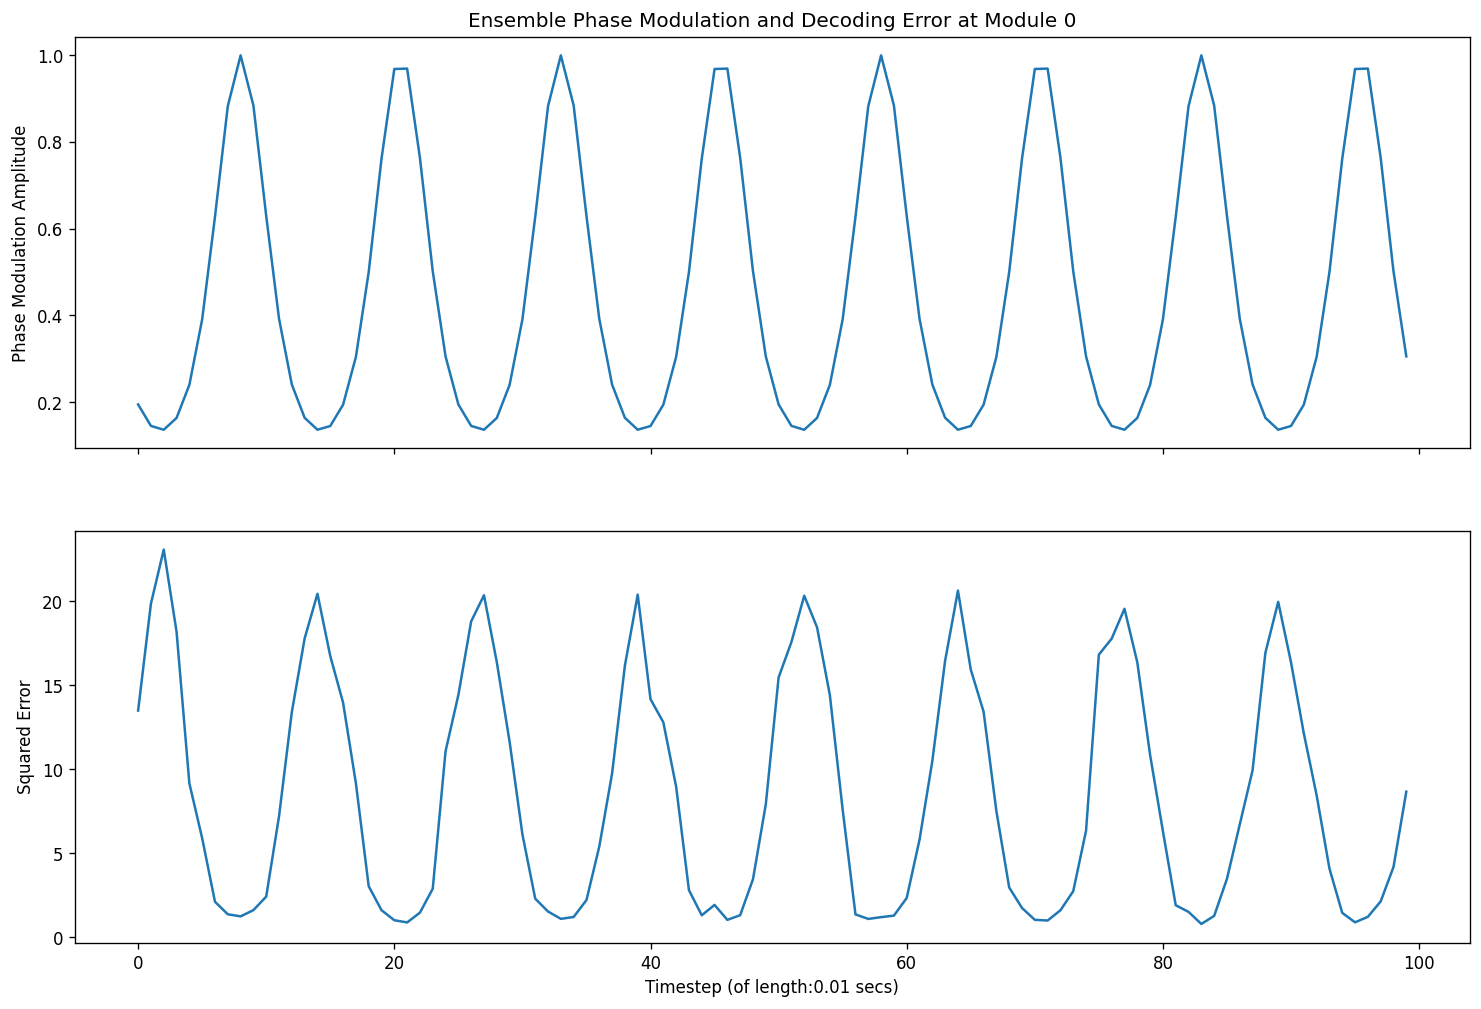

In [ ]:
#@title Ensemble for Stationary Animal

args = {'timestep_size': 0.01, # sec
        'nb_steps': 100, # simulation time = dt*nb_steps (secs)
        'nb_modules': 5,
        'nb_cells': int(1e4),
        'lam_0': 100,  #spatial period of largest module (ventral)
        'K': 50, # von-Mises tuning width
        'n_max': 20, # maximum firing rate
        'animal_velocity': 0.2, # m/sec
        'theta_freq': 8,  # Hz
        'phase_offset': 40, # degrees 
        'scaling_ratio': 1.5,
        'k_theta': 1,
        'b_theta': 0,
        'm_theta': 2*np.pi/10, # rate of theta precession
        'ref_pos': np.array([[0, 0]]),  # reference position for theta precession
        }

nb_trials = 100

error_trials = np.zeros((nb_trials, args['nb_steps']))


x = 4
y = 5
trajectory = stationary_trajectory(x, y, args)

for i in range(nb_trials):
  activity, g_rec = firing_activity(trajectory, modules, args) # shape: (nb_cells, nb_steps, nb_modules)

  # Estimating at Module - 0
  estimates = pop_decode(activity[:, :, 0], args['lam_0'], args, modules[:, :, 0])

  error_trials[i] = sq_error(estimates, trajectory) #shape:(nb_steps)

avg_sq_error = (1/nb_trials)*np.sum(error_trials, axis=0)

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(15,10), dpi=120)
axs[0].plot(g_rec[0])
axs[0].set_ylabel("Phase Modulation Amplitude")
axs[1].set_xlabel("Timestep (of length:" + str(args['timestep_size']) + ' secs)')
axs[1].set_ylabel("Squared Error")
axs[1].plot(avg_sq_error)
axs[0].set_title("Ensemble Phase Modulation and Decoding Error at Module 0")

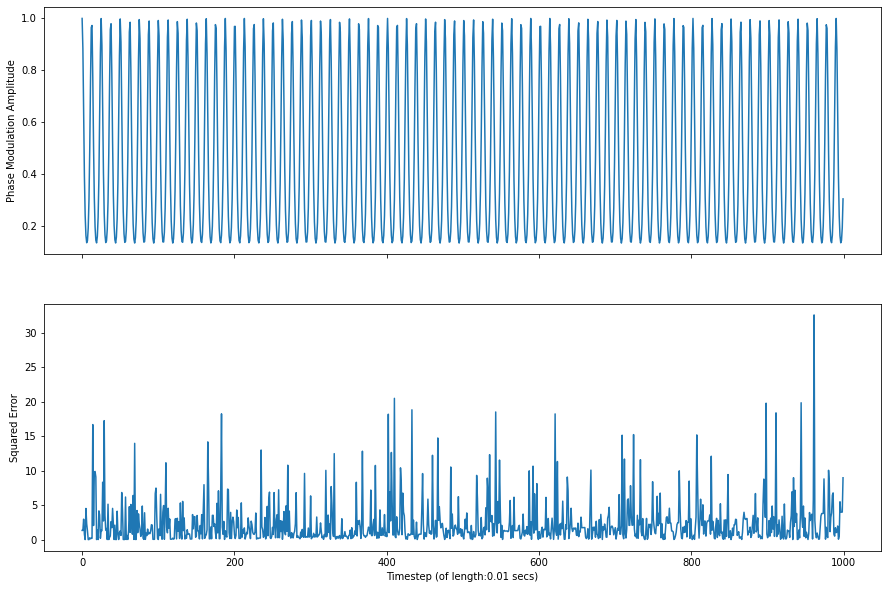

In [ ]:
#@title Animal moving along a straight line

args = {'timestep_size': 0.01, # sec
        'nb_steps': 1000, # simulation time = dt*nb_steps (secs)
        'nb_modules': 5,
        'nb_cells': int(1e4),
        'lam_0': 100,  #spatial period of largest module (ventral)
        'K': 50, # von-Mises tuning width
        'n_max': 20, # maximum firing rate
        'animal_velocity': 0.2, # m/sec
        'theta_freq': 8,  # Hz
        'phase_offset': 40, # degrees 
        'scaling_ratio': 1.5,
        'k_theta': 1,
        'b_theta': 0,
        'm_theta': 2*np.pi/10, # rate of theta precession
        'ref_pos': np.array([[0, 0]]),  # reference position for theta precession
        }

trajectory = straight_trajectory(30, args)

activity, g_rec = firing_activity(trajectory, modules, args) # shape: (nb_cells, nb_steps, nb_modules)


# Estimating at Module - 0
estimates = pop_decode(activity[:, :, 0], args['lam_0'], args, modules[:, :, 0])

error = sq_error(estimates, trajectory) #shape:

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(15,10))
axs[0].plot(g_rec[0])
axs[0].set_ylabel("Phase Modulation Amplitude")
axs[1].set_xlabel("Timestep (of length:" + str(args['timestep_size']) + ' secs)')
axs[1].set_ylabel("Squared Error")
axs[1].plot(error)

100%|██████████| 100/100 [22:36<00:00, 13.57s/it]


Text(0.5, 1.0, 'Ensemble Phase Modulation and Decoding Error at Module 0')

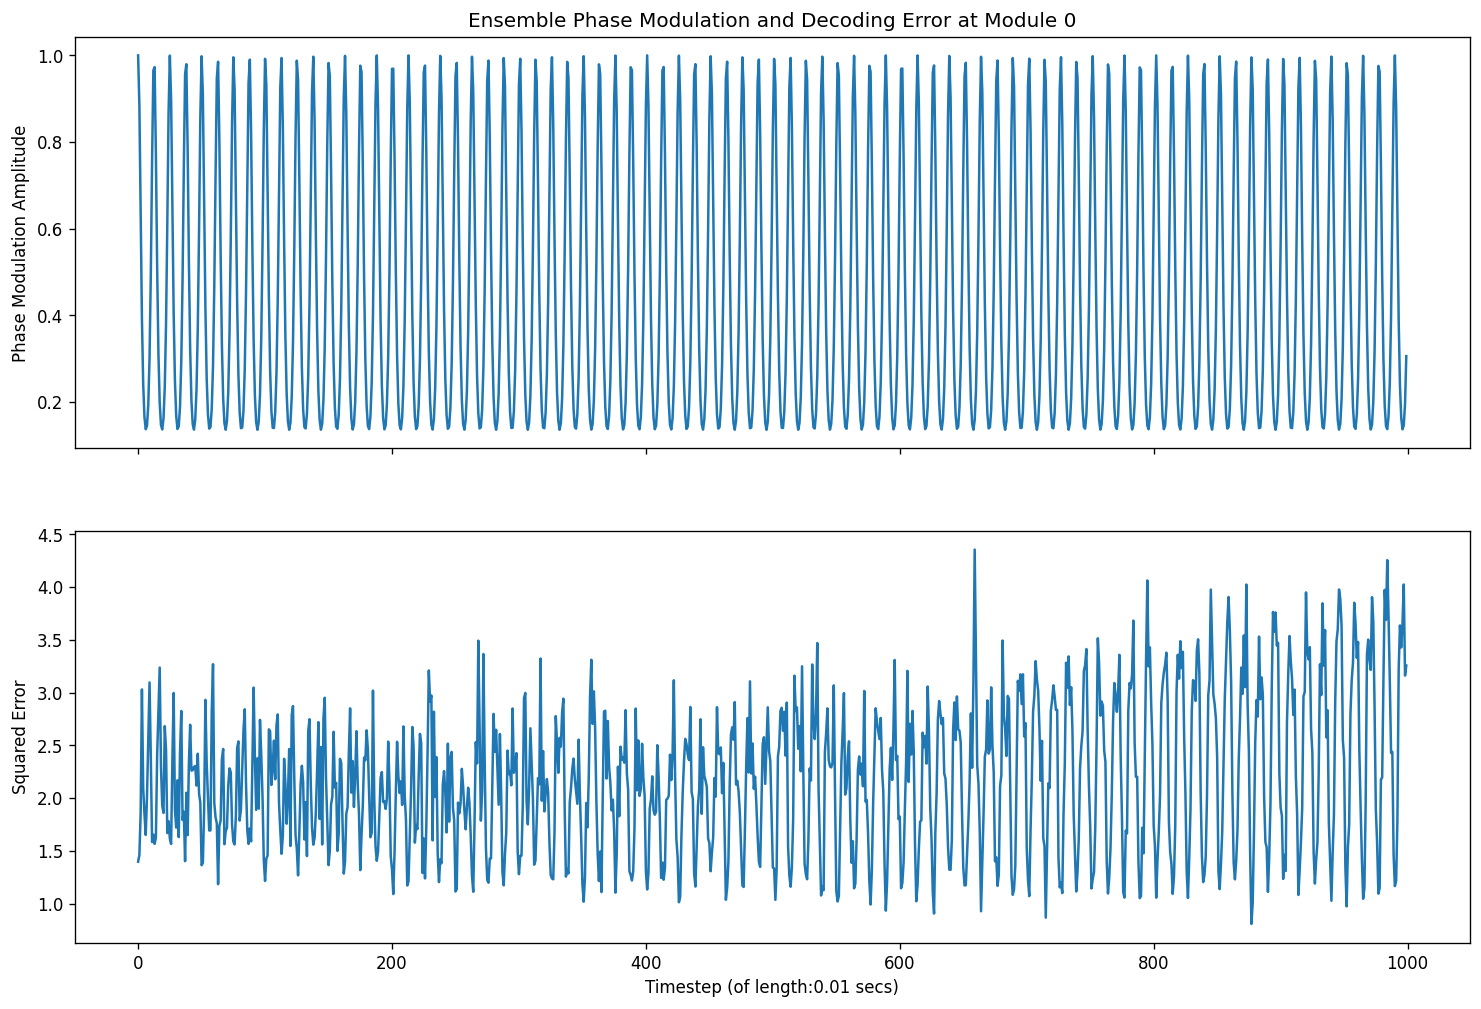

In [ ]:
#@title Ensemble for Straight Trajectory

args = {'timestep_size': 0.01, # sec
        'nb_steps': 1000, # simulation time = dt*nb_steps (secs)
        'nb_modules': 5,
        'nb_cells': int(1e4),
        'lam_0': 100,  #spatial period of largest module (ventral)
        'K': 50, # von-Mises tuning width
        'n_max': 20, # maximum firing rate
        'animal_velocity': 0.2, # m/sec
        'theta_freq': 8,  # Hz
        'phase_offset': 40, # degrees 
        'scaling_ratio': 1.5,
        'k_theta': 1,
        'b_theta': 0,
        'm_theta': 2*np.pi/10, # rate of theta precession
        'ref_pos': np.array([[0, 0]]),  # reference position for theta precession
        }

nb_trials = 100
error_trials = np.zeros((nb_trials, args['nb_steps']))

trajectory = straight_trajectory(30, args)

for i in tqdm(range(nb_trials)):
  activity, g_rec = firing_activity(trajectory, modules, args) # shape: (nb_cells, nb_steps, nb_modules)

  # Estimating at Module - 0
  estimates = pop_decode(activity[:, :, 0], args['lam_0'], args, modules[:, :, 0])

  error_trials[i] = sq_error(estimates, trajectory) #shape:(nb_steps)

avg_sq_error = (1/nb_trials)*np.sum(error_trials, axis=0)

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(15,10), dpi=120)
axs[0].plot(g_rec[0])
axs[0].set_ylabel("Phase Modulation Amplitude")
axs[1].set_xlabel("Timestep (of length:" + str(args['timestep_size']) + ' secs)')
axs[1].set_ylabel("Squared Error")
axs[1].plot(avg_sq_error)
axs[0].set_title("Ensemble Phase Modulation and Decoding Error at Module 0")


### References:

Fiete, I.R., Y. Burak, and T. Brookings. 2008. What Grid Cells Convey about Rat Location. J. Neurosci. 28:6858–6871. doi:10.1523/JNEUROSCI.5684-07.2008.

Hafting, T., M. Fyhn, S. Molden, M.-B. Moser, and E.I. Moser. 2005. Microstructure of a spatial map in the entorhinal cortex. Nature. 436:801–806. doi:10.1038/nature03721.

Hernández-Pérez, J.J., K.W. Cooper, and E.L. Newman. 2020. Medial entorhinal cortex activates in a traveling wave in the rat. eLife. 9:e52289. doi:10.7554/eLife.52289.

Herz, A.V., A. Mathis, and M. Stemmler. 2017. Periodic population codes: From a single circular variable to higher dimensions, multiple nested scales, and conceptual spaces. Curr. Opin. Neurobiol. 46:99–108. doi:10.1016/j.conb.2017.07.005.

Lubenov, E.V., and A.G. Siapas. 2009. Hippocampal theta oscillations are travelling waves. Nature. 459:534–539. doi:10.1038/nature08010.

Mathis, A., A.V.M. Herz, and M.B. Stemmler. 2013. Multiscale codes in the nervous system: The problem of noise correlations and the ambiguity of periodic scales. Phys. Rev. E. 88:022713. doi:10.1103/PhysRevE.88.022713.

McClain, K., D. Tingley, D.J. Heeger, and G. Buzsáki. 2019. Position–theta-phase model of hippocampal place cell activity applied to quantification of running speed modulation of firing rate. Proc. Natl. Acad. Sci. 116:27035–27042. doi:10.1073/pnas.1912792116.

Solstad, T., E.I. Moser, and G.T. Einevoll. 2006. From grid cells to place cells: A mathematical model. Hippocampus. 16:1026–1031. doi:10.1002/hipo.20244.

Stemmler, M., A. Mathis, and A.V.M. Herz. 2015. Connecting multiple spatial scales to decode the population activity of grid cells. Sci. Adv. 1:e1500816. doi:10.1126/science.1500816.

Stensola, H., T. Stensola, T. Solstad, K. Frøland, M.-B. Moser, and E.I. Moser. 2012. The entorhinal grid map is discretized. Nature. 492:72–78. doi:10.1038/nature11649.
